In [4]:
%load_ext autoreload
%autoreload 2
# %matplotlib widget

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = '1'

from cleanplots import *
from tqdm import tqdm
from information_estimation import gaussian_entropy_estimate, nearest_neighbors_entropy_estimate
from image_utils import *

from led_array.bsccm_utils import *
from bsccm import BSCCM
from jax import jit
import numpy as onp
import jax.numpy as np

bsccm = BSCCM('/home/hpinkard_waller/data/BSCCM/')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Opening BSCCM
Opened BSCCM


In [28]:
# generate multivariate gaussian data
X = onp.random.multivariate_normal(onp.zeros(8), onp.eye(8), size=10000)

print(gaussian_entropy_estimate(X, stationary=True))
print(nearest_neighbors_entropy_estimate(X, k=10))

16.35948
16.16771


In [76]:
def create_images(size, type, num_images, channel=None,
                   num_images_for_cov_estimation=10000, num_patches=50000, edge_crop=32, 
                   median_filter=False):
    """
    Get a distribution of images 

    Parameters
    ----------
    size : int  size of images
    type : str  'led_array' for BSCCM images, 'stationary_GP' for gaussian process images derived
                from BSCCM images
    num_images : int  number of images to generate
    channel : str  channel to use for BSCCM images
    num_images_for_cov_estimation : int  number of BSCCM images to use for covariance estimation
    num_patches : int  number of patches to use for covariance estimation   
    edge_crop : int  number of pixels to crop from the edge of BSCCM images when estimating covariance
    median_filter : bool  whether to median filter BSCCM images
    """
    if type == 'stationary_GP':
        # Generate gaussian process images based on the statistics of LED array images of cells
        patch_size = size # the size of patches to estimate the covariance matrix from
        images = load_bsccm_images(bsccm, channel, num_images=num_images_for_cov_estimation, 
                                   edge_crop=edge_crop, convert_units_to_photons=True, median_filter=median_filter)
        patches = extract_patches(images, patch_size=patch_size, num_patches=num_patches, seed=1234)
        print('computing cov mat')
        cov_mat = compute_stationary_cov_mat(patches)
        mean = np.mean(patches)
        print('making positive definite')
        cov_mat = make_positive_definite(cov_mat, cutoff_percentile=25, show_plot=False)
        # ensure that it is a valid covariance matrix
        non_symmetric_deviation = np.abs(cov_mat - cov_mat.T)
        if np.any(non_symmetric_deviation > 0):
            percentage_error = non_symmetric_deviation / np.mean(cov_mat)
            warnings.warn(f'Making covariance matrix symmetric, current deviation is {np.max(percentage_error)}% of the mean')
            cov_mat = (cov_mat + cov_mat.T) / 2

        images, patches = None, None # free memory
        # generate images

        mean = 1000
        print('settting the mean to something crazy...TODO chagne back')
        images = generate_stationary_gaussian_process_samples(cov_mat, size, num_images, mean=mean, ensure_nonnegative=True)
        
        return np.array(images), cov_mat
    elif type == 'led_array':
        # load median filtered images of cells from LED array
        crop_size = bsccm.global_metadata['led_array']['image_shape'][0] - 2 * edge_crop
        images = load_bsccm_images(bsccm, channel, num_images=num_images, 
                                   edge_crop=edge_crop, convert_units_to_photons=True,
                                   median_filter=median_filter)
        # for each image, crop to a random square patch
        num_images = images.shape[0]
        cropped_images = []
        for image in images:
            # choose a random location to crop from
            x = onp.random.randint(0, crop_size - size)
            y = onp.random.randint(0, crop_size - size)
            # crop the image
            cropped_images.append(image[y:y + size, x:x + size])
        return np.array(cropped_images)
    else:
        raise ValueError('type must be led_array or stationary_GP')


@jit
def compute_conditional_entropy(images, gaussian_noise_sigma=None):
    """
    Compute the conditional entropy H(Y | X) where Y is a random noisy
    realization of a random clean image X

    images : ndarray clean image HxW or images NxHxW
    """
    # vectorize
    images = images.reshape(-1, images.shape[-2] * images.shape[-1])
    
    if gaussian_noise_sigma is None:
        
        # conditional entropy H(Y | x) for Poisson noise (see derivation in paper)
        return np.mean(0.5 * (images.shape[0] * np.log2(2 * np.pi * np.e) + np.sum(np.log2(images), axis=1)))
    else:
        # conditional entropy H(Y | x) for Gaussian noise
        # only depends on the gaussian sigma
        return np.mean(np.sum(images.shape[-1] * 0.5 * np.log2(2 * np.pi * np.e * gaussian_noise_sigma**2), axis=1))
    
        

## Is H(Y | X) well approximated by H(Y_theoretical | Y_experimental)

100%|██████████| 50000/50000 [00:00<00:00, 1027562.35it/s]


computing cov mat


100%|██████████| 19/19 [00:00<00:00, 119.23it/s]
/tmp/ipykernel_7282/3264924191.py:34: UserWarning: Making covariance matrix symmetric, current deviation is 2.483420473708975e-07% of the mean
  warnings.warn(f'Making covariance matrix symmetric, current deviation is {np.max(percentage_error)}% of the mean')


making positive definite
Matrix not positive definite. Adding 64.34979248046875 to eigenvalues
settting the mean to something crazy...TODO chagne back
precomputing masks and variances


generating samples: 100%|██████████| 1000/1000 [00:11<00:00, 89.11it/s]


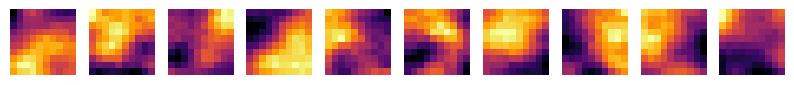

In [46]:
# generate images and plot a montage
size = 10
num_images = 1000
# channel = 'DPC_Right'
channel = 'LED119'

# images = create_images(size, 'led_array', num_images, channel=channel, median_filter=True, edge_crop=32)  
images, cov_mat = create_images(size, 'stationary_GP', num_images, channel=channel, median_filter=True, edge_crop=32)  

# plot a montage of images
num_to_plot = 10
fig, ax = plt.subplots(1, num_to_plot, figsize=(num_to_plot, 1))
for i in range(num_to_plot):
    ax[i].imshow(images[i], cmap='inferno')
    ax[i].axis('off')




In [23]:
# def estimate_mutual_information(images):
#     H_y = gaussian_entropy_estimate(noisy_images.reshape(noisy_images.shape[0], -1))
    

noisy_images = np.array(add_shot_noise(images))

h_y_given_x_true = compute_conditional_entropy(images)
h_y_given_x_noisy_approx = compute_conditional_entropy(noisy_images)

print('conditional entropy clean: ', h_y_given_x_true)
print('conditional entropy noisy approx: ', h_y_given_x_noisy_approx)


h_y_gaussian = gaussian_entropy_estimate(noisy_images, stationary=False)
h_y_nearest_neighbors = nearest_neighbors_entropy_estimate(noisy_images, k=10)

print('h_y_gaussian: ', h_y_gaussian, 'h_y_nearest_neighbors: ', h_y_nearest_neighbors)


conditional entropy clean:  20968.682
conditional entropy noisy approx:  20968.643
h_y_gaussian:  751.9753 h_y_nearest_neighbors:  200.42355


In [103]:

def multivariate_gaussian_entropy(cov_matrix):
    """
    Numerically stable computation of the entropy of a multivariate gaussian
    """
    d = cov_matrix.shape[0]
    det_cov_matrix = np.linalg.det(cov_matrix)
    if np.isinf(det_cov_matrix):
        raise ValueError('Determinant of covariance matrix is infinite')
    entropy = 0.5 * d * np.log2(2 * np.pi * np.e) + 0.5 * np.sum(np.log2(np.linalg.eigvalsh(cov_matrix)))
    return entropy

# determined from experimental data
# cov_mat_to_use = cov_mat / np.max(cov_mat)

# # identity cov mat
# cov_mat = np.eye(8)
# cov_mat_to_use = cov_mat

# generate a random 8x8 covariance matrix
cov_mat_random = onp.random.randn(8, 8)
cov_mat_random = cov_mat_random.T @ cov_mat_random
cov_mat_to_use = cov_mat_random


X = onp.random.multivariate_normal(onp.zeros(cov_mat_to_use.shape[0]), cov_mat_to_use, size=20000)

print('cov matrix estimate gaussian entropy', gaussian_entropy_estimate(X, stationary=False))
print('analytical gaussian entropy', multivariate_gaussian_entropy(cov_mat_to_use))
print('nearest neighbors entropy', nearest_neighbors_entropy_estimate(X, k=1))

# make a plot of the nearest neighbors entropy estimate as a function of k
k_values = onp.arange(25)
entropies_knn = []
for k in tqdm(k_values):
    entropies_knn.append(nearest_neighbors_entropy_estimate(X, k=k))


# plot the entropy as a function of k
fig, ax = plt.subplots(1, 1)
ax.plot(k_values, entropies_knn)
ax.set_xlabel('k')
ax.set_ylabel('entropy estimate')

# plot the analytical entropy as a horizontal line
ax.axhline(multivariate_gaussian_entropy(cov_mat_to_use), color='k', linestyle='--')

cov matrix estimate gaussian entropy 21.275219
analytical gaussian entropy 21.29559
nearest neighbors entropy 25.469898


 48%|████▊     | 12/25 [00:27<00:29,  2.28s/it]


XlaRuntimeError: INTERNAL: Failed to load in-memory CUBIN: CUDA_ERROR_INVALID_DEVICE: invalid device ordinal